In [1]:
import gc 
from typing import Tuple, Dict, List
from pathlib import Path
import numpy as np
import os
import sys


# Oder absoluten Pfad zum utils-Ordner
sys.path.append('/dss/dsshome1/08/di97ren/04-geo-oma24/assignment_04_geo_oma24-xView2/utils')

#from utils.helper import iterate_through_dir
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
#from utils.datasetClass import xView2Dataset, image_transform, transform, collate_fn
import torchvision.models as models
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
#from utils.model import UNet_ResNet50, SiameseUnet, train_step, val_step
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from torch.utils.tensorboard import SummaryWriter

In [2]:
class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: callable = None,
                 transform: callable = None,
                 image_transform: callable = None,
                 inference = False):

        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        self.inference = inference

        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            if self.inference: 
                if post_img_path.exists():
                    self.pairs.append((pre_img_path, post_img_path))
            else: 
                # Nur im Trainingsmodus benötigen wir target_path
                if self.target_path is None:
                    raise ValueError("target_path must be provided when not in inference mode")
                    
                post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
                pre_target_path = self.target_path / pre_img_path.name

                if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                    self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):

        if self.inference:
            pre_img_path, post_img_path = self.pairs[index]

            # Load images
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")

            # Convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0

            # Convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            
            if self.image_transform:
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_img_path.name, post_img_path.name

        else:
            pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

            # load images and target masks with 
            
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")
            pre_target_mask = Image.open(pre_target_path).convert('L')
            post_target_mask = Image.open(post_target_path).convert('L')

            # convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0
            pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
            post_target_mask = np.array(post_target_mask, dtype=np.float32)

            # convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
            post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

            # Transformation (optional)
            if self.transform:
                stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
                stack = self.transform(stack)

                pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
            
            if self.image_transform:
                # Nur auf Bilder Normalisierung anwenden
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_target_mask, post_target_mask 
    
def collate_fn_test(batch):
    pre_imgs, post_imgs, pre_names, post_names = zip(*batch)
    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)

    return pre_imgs, post_imgs, pre_names, post_names

Define Testroot and Dataloader

In [3]:

def iterate_through_dir(directory_path):
    for directory_path, directorynames, filenames in os.walk(directory_path):
        print(f"There are {len(directorynames)} directories and {len(filenames)} images in '{directory_path}'.")


def transform():
    """Transform für Bilder & Masken"""
    return v2.Compose([
        v2.RandomHorizontalFlip(p = 0.5),
        v2.RandomVerticalFlip(p = 0.5),
        #v2.RandomRotation(degrees=15),
       # v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        v2.ToDtype(torch.float32, scale=True)  # Automatische Skalierung auf [0,1]
    ])

def image_transform():
    """Nur für RGB-Bilder"""
    return v2.Compose([
       # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: str,
                 transform: callable = None,
                 image_transform: callable = None
                 ):
        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        
        
        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] 

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
            pre_target_path = pre_target_path = self.target_path / pre_img_path.name


            if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

        # super().__init__()

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, index):
        pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

        # load images and target masks with 
        
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        pre_target_mask = Image.open(pre_target_path).convert('L')
        post_target_mask = Image.open(post_target_path).convert('L')

        # convert to numpy arrays
        pre_img = np.array(pre_img, dtype=np.float32) / 255.0
        post_img = np.array(post_img, dtype=np.float32) / 255.0
        pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
        post_target_mask = np.array(post_target_mask, dtype=np.float32)

        # convert to Tensor
        pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        post_img = torch.tensor(post_img).permute(2, 0, 1)
        pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
        post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

    # Transformation (optional)


        if self.transform:
            stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
            stack = self.transform(stack)

            pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
        
        if self.image_transform:
            
            # Nur auf Bilder Normalisierung anwenden
            pre_img = self.image_transform(pre_img)
            post_img = self.image_transform(post_img)

        return pre_img, post_img, pre_target_mask, post_target_mask 
    

    
def collate_fn(batch):
      # Extrahieren der einzelnen Daten aus der Batch-Liste
    pre_imgs, post_imgs, pre_masks, post_masks = zip(*batch)

    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)
    pre_masks = torch.stack(pre_masks, dim=0)
    post_masks = torch.stack(post_masks, dim=0)

    return pre_imgs, post_imgs, pre_masks, post_masks



In [4]:
# Define all pathes

In [5]:
# HPC Terrabyte
# adapt the user to your needs
USER = "di97ren"
# keep the following unchanged
ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
USER_PATH = ROOT / f"users/{USER}"
DATA_PATH = ROOT / "data"


# Configure the path to the xview2 dataset for your environment
DATASET_ROOT = DATA_PATH / "xview2-subset"

TRAIN_ROOT = DATASET_ROOT / "tier1"
TRAIN_IMG = TRAIN_ROOT / "png_images"
TRAIN_TARGET = TRAIN_ROOT / 'targets'

VAL_ROOT = DATASET_ROOT / "hold"
VAL_IMG = VAL_ROOT / "png_images"
VAL_TARGET = VAL_ROOT / 'targets'


TEST_ROOT = DATASET_ROOT / "test"
TEST_IMG = TEST_ROOT / "png_images"


EXPERIMENT_GROUP = "xView2"
EXPERIMENT_ID = "UNet_005"

# HPC Terrabyte path config
EXPERIMENT_DIR = USER_PATH / f"experiments/{EXPERIMENT_GROUP}"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINTS_DIR = USER_PATH / f"checkpoints/{EXPERIMENT_GROUP}"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)



# Create Training and Validation Datasets

In [6]:
train_dataset = xView2Dataset(png_path = TRAIN_IMG,
                 target_path = TRAIN_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

val_dataset = xView2Dataset(png_path = VAL_IMG ,
                 target_path = VAL_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

train_dataset, val_dataset
len(train_dataset), len(val_dataset)

(2798, 750)

## Create Controll Plots

In [7]:
import matplotlib.pyplot as plt

def create_Control_plots(Dataset_Sample):
    pre_img, post_img, pre_target, post_target = Dataset_Sample

    # Konvertiere die Tensoren zurück zu NumPy-Arrays für die Anzeige
    pre_img_np = pre_img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    post_img_np = post_img.permute(1, 2, 0).numpy()
    pre_mask_np = pre_target.squeeze().numpy()  # (1, H, W) → (H, W)
    post_mask_np = post_target.squeeze().numpy()

    # Skaliere die Bilder zurück auf den Bereich [0, 255]
    pre_img_np = pre_img_np * 255.0
    post_img_np = post_img_np * 255.0

    # Erstelle eine Liste der Farben für jede Klasse
    colors = {
        0: 'white',       # Background
        1: 'green',       # No damage
        2: 'yellow',      # Minor damage
        3: 'orange',      # Major damage
        4: 'red'          # Destroyed
    }

    # Erstelle ein 2x2-Subplot für die Bilder
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Visualisiere die Bilder
    axes[0, 0].imshow(pre_img_np.astype(np.uint8))  # Achte darauf, dass die Daten im richtigen Bereich sind
    axes[0, 0].set_title("Pre-Disaster Image")
    axes[0, 1].imshow(post_img_np.astype(np.uint8))  # Achte darauf, dass die Daten im richtigen Bereich sind
    axes[0, 1].set_title("Post-Disaster Image")
    axes[1, 0].imshow(pre_mask_np, cmap='gray')  # Pre-mask mit Graustufen
    axes[1, 0].set_title("Pre-Mask")
    axes[1, 1].imshow(post_mask_np, cmap=plt.cm.colors.ListedColormap([colors[0], colors[1], colors[2], colors[3], colors[4]]))
    axes[1, 1].set_title("Post-Mask")

    # Erstelle eine zusätzliche Achse für die Legende
    fig.subplots_adjust(bottom=0.2)  # Platz für die Legende unten schaffen
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.05])  # [left, bottom, width, height] in fraction der Figur

    # Füge die Legende hinzu (horizontal)
    cbar = plt.colorbar(axes[1, 1].imshow(post_mask_np, cmap=plt.cm.colors.ListedColormap([colors[0], colors[1], colors[2], colors[3], colors[4]])),
                        cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Damage Class')
    cbar.set_ticks([0, 1, 2, 3, 4])
    cbar.set_ticklabels(['Background', 'Building/No Damage', 'Minor Damage', 'Major Damage', 'Destroyed'])

    # Anzeige der Plots
    #plt.tight_layout()
    plt.show()


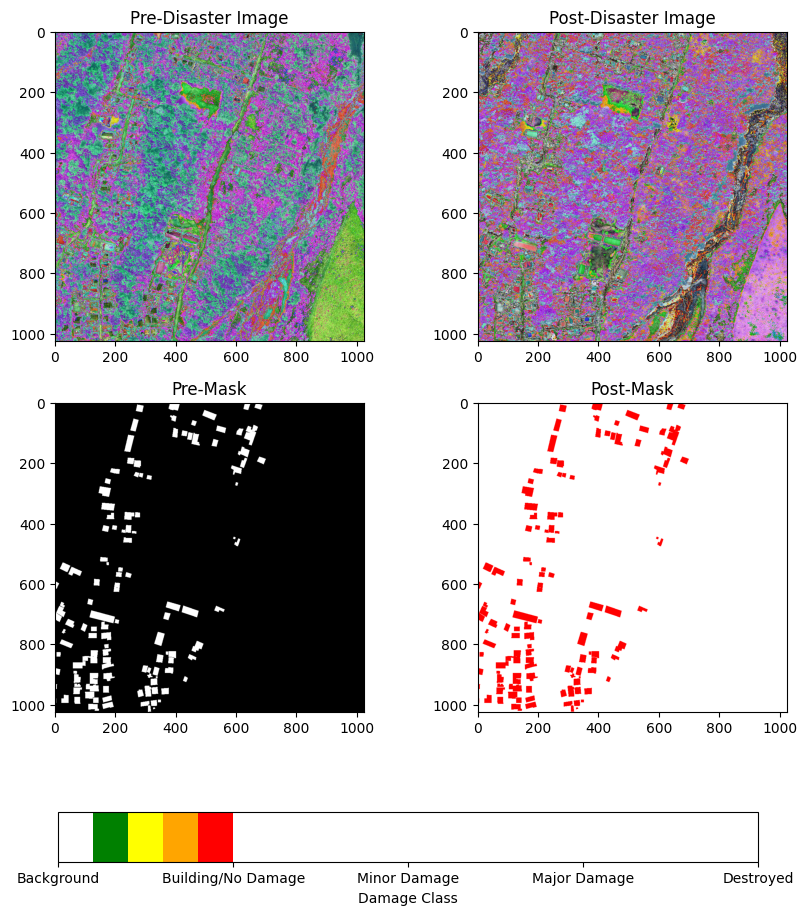

In [8]:
train_control = create_Control_plots(train_dataset[8])


# Trainingsvorbereitungen
berechnen von ungleichbewichten in der Klassenverteilung 

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

In [10]:
import torch
import numpy as np
from collections import Counter
from tqdm import tqdm  # Optional, für Fortschrittsanzeige

def calculate_class_counts(dataset):
    pre_class_counts = Counter()
    post_class_counts = Counter()
    
    # Durch den gesamten Datensatz iterieren
    for i in tqdm(range(len(dataset)), desc="Berechne Klassenverteilung"):
        # Annahme: Dataset gibt ein Tuple (pre_img, post_img, pre_mask, post_mask) zurück
        _, _, pre_mask, post_mask = dataset[i]
        
        # Konvertiere zu NumPy, falls es ein Torch-Tensor ist
        if isinstance(pre_mask, torch.Tensor):
            pre_mask = pre_mask.numpy()
        if isinstance(post_mask, torch.Tensor):
            post_mask = post_mask.numpy()
        
        # Zähle die Vorkommen jeder Klasse in den Masken
        # Für pre_mask (typischerweise Klassen 0 und 1)
        pre_classes = np.unique(pre_mask)
        for cls in pre_classes:
            pre_class_counts[int(cls)] += np.sum(pre_mask == cls)
        
        # Für post_mask (typischerweise Klassen 0 bis 5)
        post_classes = np.unique(post_mask)
        for cls in post_classes:
            post_class_counts[int(cls)] += np.sum(post_mask == cls)
    
    return pre_class_counts, post_class_counts

from collections import Counter

def calculate_class_weights(class_counts):
    total = sum(class_counts.values())
    weights = {cls: total / count for cls, count in class_counts.items()}
    # Normalize weights
    sum_weights = sum(weights.values())
    weights = {cls: weight / sum_weights * len(weights) for cls, weight in weights.items()}
    return weights

In [11]:
# Verwendung:
pre_counts, post_counts = calculate_class_counts(train_dataset)

print("Pre-Disaster Klassenverteilung:")
for cls, count in pre_counts.items():
    print(f"  Klasse {cls}: {count} Pixel")

print("\nPost-Disaster Klassenverteilung:")
for cls, count in post_counts.items():
    print(f"  Klasse {cls}: {count} Pixel")




Berechne Klassenverteilung:   0%|          | 0/2798 [00:00<?, ?it/s]

Berechne Klassenverteilung:   1%|          | 34/2798 [00:07<09:59,  4.61it/s]


KeyboardInterrupt: 

In [ ]:


# Calculate weights
pre_weights = calculate_class_weights(pre_counts)
post_weights = calculate_class_weights(post_counts)

# Convert to tensors
class_weights_pre = torch.tensor([pre_weights.get(0, 1.0), pre_weights.get(1, 10.0)], device=device)
class_weights_post = torch.tensor([
    post_weights.get(0, 1.0), 
    post_weights.get(1, 10.0),
    post_weights.get(2, 30.0),
    post_weights.get(3, 20.0),
    post_weights.get(4, 50.0),
    post_weights.get(5, 100.0)
], device=device)

criterion_pre = nn.CrossEntropyLoss(weight=class_weights_pre)
criterion_post = nn.CrossEntropyLoss(weight=class_weights_post)

# Umwandlung in Tensoren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_pre = torch.tensor([pre_weights.get(0, 1.0), pre_weights.get(1, 10.0)], device=device)
class_weights_post = torch.tensor([
    post_weights.get(0, 1.0), 
    post_weights.get(1, 10.0),
    post_weights.get(2, 30.0),
    post_weights.get(3, 20.0),
    post_weights.get(4, 50.0),
    post_weights.get(5, 100.0)
], device=device)

## Define Focal Loss and Combined Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss for handling class imbalance
        
        Args:
            alpha: Weight for each class (list or tensor)
            gamma: Focusing parameter to down-weight easy examples
            reduction: 'mean', 'sum' or 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Model predictions (B, C, H, W)
            targets: Ground truth labels (B, H, W)
        """
        # Typenkonvertierung hinzufügen
        inputs = inputs.float()
        targets = targets.long()
        
        B, C, H, W = inputs.size()
        
        # Reshape inputs and targets
        inputs = inputs.permute(0, 2, 3, 1).contiguous().view(-1, C)  # (B*H*W, C)
        targets = targets.view(-1)  # (B*H*W)
        
        # Compute cross entropy loss
        weight = self.alpha.float() if self.alpha is not None else None
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
        
        # Compute probabilities
        probs = F.softmax(inputs, dim=1)
        probs_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)  # Get the probability of the target class
        
        # Apply focal weighting
        focal_weight = (1 - probs_t) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss

    
    # def forward(self, inputs, targets):
    #     # Ensure both inputs and targets are float32
    #     inputs = inputs.float()
    #     targets = targets.long()
        
    #     # Don't convert targets to float if they're supposed to be long/int for CrossEntropyLoss
    #     # targets = targets.long()  # CrossEntropyLoss expects class indices as Long
        
    #     ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        
    #     pt = torch.exp(-ce_loss)
    #     focal_loss = (1 - pt) ** self.gamma * ce_loss
        
    #     if self.reduction == 'mean':
    #         return focal_loss.mean()
    #     elif self.reduction == 'sum':
    #         return focal_loss.sum()
    #     else:
    #         return focal_loss

        
    # def forward(self, inputs, targets):
    #     """
    #     Args:
    #         inputs: Model predictions (B, C, H, W)
    #         targets: Ground truth labels (B, H, W)
    #     """
    #     B, C, H, W = inputs.size()
        
    #     # Reshape inputs and targets
    #     inputs = inputs.permute(0, 2, 3, 1).contiguous().view(-1, C)  # (B*H*W, C)
    #     targets = targets.view(-1)  # (B*H*W)
        
    #     # Compute cross entropy loss
    #     ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        
    #     # Compute probabilities
    #     probs = F.softmax(inputs, dim=1)
    #     probs_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)  # Get the probability of the target class
        
    #     # Apply focal weighting
    #     focal_weight = (1 - probs_t) ** self.gamma
    #     focal_loss = focal_weight * ce_loss
        
    #     # Apply reduction
    #     if self.reduction == 'mean':
    #         return focal_loss.mean()
    #     elif self.reduction == 'sum':
    #         return focal_loss.sum()
    #     else:  # 'none'
    #         return focal_loss
        

# Combined loss function for training
def combined_loss_function(outputs, pre_masks, post_masks):
    pre_outputs = outputs[:, :2]  # First 2 channels
    post_outputs = outputs[:, 2:]  # Remaining channels
    
    # Calculate focal losses
    pre_loss = focal_loss_pre(pre_outputs, pre_masks)
    post_loss = focal_loss_post(post_outputs, post_masks)
    
    # Combine losses (you can adjust weights)
    total_loss = pre_loss + post_loss
    return total_loss

In [ ]:

# IoU-Berechnung
def calculate_iou(pred, target, cls):
    pred_mask = (pred == cls)
    target_mask = (target == cls)
    intersection = (pred_mask & target_mask).sum().item()
    union = (pred_mask | target_mask).sum().item()
    if union > 0:
        return intersection / union
    return 0

In [ ]:
# Implement weighted sampling in your DataLoader
from torch.utils.data import WeightedRandomSampler

# Calculate sample weights based on class representation
def get_sample_weights(dataset):
    # This is just an example - you'll need to adapt it to your specific dataset structure
    sample_weights = []
    for i in range(len(dataset)):
        _, _, pre_mask, post_mask = dataset[i]
        # Count rare classes in this sample
        rare_class_count = (pre_mask == 1).sum() + sum((post_mask == c).sum() for c in [1, 2, 3, 4, 5])
        weight = 1 + rare_class_count.item() * 0.1  # Adjust the multiplier as needed
        sample_weights.append(weight)
    return sample_weights



# Model Implementierung

In [ ]:
# eventuell Class attention Module?        
class UNet_ResNet50(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Load ResNet50 als Encoder
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        # Encoder-Pfad
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # Decoder mit progressivem Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        # Finale Klassifikationsschicht
        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Speichere Ursprungsgröße
        original_size = x.shape[2:]
        
        try:
            # Encoder-Durchgang
            features = self.encoder(x)
            #print(f"Encoder Output Shape: {features.shape}")

            # Decoder-Durchgang
            decoder_out = self.decoder(features)
            #print(f"Decoder Output Shape: {decoder_out.shape}")

            # Finale Konvolution
            out = self.final_conv(decoder_out)
            #print(f"Final Conv Output Shape: {out.shape}")

            # Upsample auf Originalgröße
            out = F.interpolate(out, size=original_size, mode='bilinear', align_corners=False)
            #print(f"Final Interpolated Output Shape: {out.shape}")

            return out

        except Exception as e:
            print(f"Error in forward pass: {e}")
            raise




class SiameseUnet(nn.Module):
    def __init__(self, num_pre_classes=2, num_post_classes=6):
        super(SiameseUnet, self).__init__()

        self.unet_preDisaster = UNet_ResNet50(n_class=num_pre_classes)
        self.unet_postDisaster = UNet_ResNet50(n_class=num_post_classes)

        # Fusion-Layer kombiniert prä- und post-Klassifikationen
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(num_pre_classes + num_post_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_pre_classes + num_post_classes, kernel_size=1)
        )

    def forward(self, pre_image, post_image):
        pre_output = self.unet_preDisaster(pre_image)
        post_output = self.unet_postDisaster(post_image)

        # Konkatenieren der Ausgaben
        fused_output = torch.cat([pre_output, post_output], dim=1)

        # Fusion der Features
        final_output = self.fusion_layer(fused_output)

        return final_output


## Train and Validation Step

In [ ]:

# # Updated train_step function
# def train_step(model, dataloader, optimizer, epoch):
#     model.train()
#     train_loss = 0.0
    
#     precision_pre = MulticlassPrecision(num_classes=2).to(device)
#     recall_pre = MulticlassRecall(num_classes=2).to(device)
#     f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
#     precision_post = MulticlassPrecision(num_classes=6).to(device)
#     recall_post = MulticlassRecall(num_classes=6).to(device)
#     f1_post = MulticlassF1Score(num_classes=6).to(device)
    
#     # Track IoU for each class
#     iou_pre = {0: 0, 1: 0}
#     iou_post = {i: 0 for i in range(6)}
#     sample_count = 0
    
#     for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
#         X_pre = pre_imgs.to(device)
#         y_pre = pre_masks.to(device)
#         X_post = post_imgs.to(device)
#         y_post = post_masks.to(device)
        
#         # Prepare masks for metrics
#         y_pre_metric = y_pre.squeeze(1).long()
#         y_post_metric = y_post.squeeze(1).long()

#         # Forward pass
#         pred = model(X_pre, X_post)
        
#         # Calculate loss using combined loss function
#         loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
        
#         # Backward pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Track loss
#         train_loss += loss.item()
        
#         # Get predictions
#         pre_pred = torch.argmax(pred[:, :2], dim=1)
#         post_pred = torch.argmax(pred[:, 2:], dim=1)
        
#         # Update metrics
#         precision_pre.update(pred[:, :2], y_pre_metric)
#         recall_pre.update(pred[:, :2], y_pre_metric)
#         f1_pre.update(pred[:, :2], y_pre_metric)
        
#         precision_post.update(pred[:, 2:], y_post_metric)
#         recall_post.update(pred[:, 2:], y_post_metric)
#         f1_post.update(pred[:, 2:], y_post_metric)
        
#         # Calculate IoU for each class
#         batch_size = y_pre.size(0)
#         sample_count += batch_size
        
#         for b in range(batch_size):
#             # Pre-disaster IoU
#             for cls in [0, 1]:
#                 iou_pre[cls] += calculate_iou(pre_pred[b].cpu(), y_pre_metric[b].cpu(), cls)
            
#             # Post-disaster IoU
#             for cls in range(6):
#                 iou_post[cls] += calculate_iou(post_pred[b].cpu(), y_post_metric[b].cpu(), cls)
    
#     # Calculate average metrics
#     avg_train_loss = train_loss / len(dataloader)
    
#     precision_pre_value = precision_pre.compute()
#     recall_pre_value = recall_pre.compute()
#     f1_pre_value = f1_pre.compute()
    
#     precision_post_value = precision_post.compute()
#     recall_post_value = recall_post.compute()
#     f1_post_value = f1_post.compute()
    
#     # Calculate average IoU
#     avg_iou_pre = {cls: val / sample_count for cls, val in iou_pre.items()}
#     avg_iou_post = {cls: val / sample_count for cls, val in iou_post.items()}
#     mean_iou_pre = sum(avg_iou_pre.values()) / len(avg_iou_pre)
#     mean_iou_post = sum(avg_iou_post.values()) / len(avg_iou_post)
    
#     # TensorBoard Logging
#     writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    
#     # Logging for pre-disaster metrics
#     writer.add_scalar("Precision_Pre/Train", precision_pre_value.mean(), epoch)
#     writer.add_scalar("Recall_Pre/Train", recall_pre_value.mean(), epoch)
#     writer.add_scalar("F1_Score_Pre/Train", f1_pre_value.mean(), epoch)
#     writer.add_scalar("IoU_Pre/Train", mean_iou_pre, epoch)
    
#     # Class-specific IoU logging for pre-disaster
#     for cls, iou in avg_iou_pre.items():
#         writer.add_scalar(f"IoU_Pre_Class_{cls}/Train", iou, epoch)
    
#     # Logging for post-disaster metrics
#     writer.add_scalar("Precision_Post/Train", precision_post_value.mean(), epoch)
#     writer.add_scalar("Recall_Post/Train", recall_post_value.mean(), epoch)
#     writer.add_scalar("F1_Score_Post/Train", f1_post_value.mean(), epoch)
#     writer.add_scalar("IoU_Post/Train", mean_iou_post, epoch)
    
#     # Class-specific IoU logging for post-disaster
#     for cls, iou in avg_iou_post.items():
#         writer.add_scalar(f"IoU_Post_Class_{cls}/Train", iou, epoch)
    
#     return avg_train_loss

# # Updated val_step function
# def val_step(model, dataloader, epoch):
#     model.eval()
#     val_loss = 0.0
    
#     precision_pre = MulticlassPrecision(num_classes=2).to(device)
#     recall_pre = MulticlassRecall(num_classes=2).to(device)
#     f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
#     precision_post = MulticlassPrecision(num_classes=6).to(device)
#     recall_post = MulticlassRecall(num_classes=6).to(device)
#     f1_post = MulticlassF1Score(num_classes=6).to(device)
    
#     # Track IoU for each class
#     iou_pre = {0: 0, 1: 0}
#     iou_post = {i: 0 for i in range(6)}
#     sample_count = 0
    
#     with torch.no_grad():
#         for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
#             X_pre = pre_imgs.to(device)
#             y_pre = pre_masks.to(device)
#             X_post = post_imgs.to(device)
#             y_post = post_masks.to(device)
            
#             # Prepare masks for metrics
#             y_pre_metric = y_pre.squeeze(1).long()
#             y_post_metric = y_post.squeeze(1).long()
            
#             # Forward pass
#             pred = model(X_pre, X_post)
            
#             # Calculate loss using combined loss function
#             loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
#             val_loss += loss.item()
            
#             # Get predictions
#             pre_pred = torch.argmax(pred[:, :2], dim=1)
#             post_pred = torch.argmax(pred[:, 2:], dim=1)
            
#             # Update metrics
#             precision_pre.update(pred[:, :2], y_pre_metric)
#             recall_pre.update(pred[:, :2], y_pre_metric)
#             f1_pre.update(pred[:, :2], y_pre_metric)
            
#             precision_post.update(pred[:, 2:], y_post_metric)
#             recall_post.update(pred[:, 2:], y_post_metric)
#             f1_post.update(pred[:, 2:], y_post_metric)
            
#             # Calculate IoU for each class
#             batch_size = y_pre.size(0)
#             sample_count += batch_size
            
#             for b in range(batch_size):
#                 # Pre-disaster IoU
#                 for cls in [0, 1]:
#                     iou_pre[cls] += calculate_iou(pre_pred[b].cpu(), y_pre_metric[b].cpu(), cls)
                
#                 # Post-disaster IoU
#                 for cls in range(6):
#                     iou_post[cls] += calculate_iou(post_pred[b].cpu(), y_post_metric[b].cpu(), cls)
    
#     # Calculate average metrics
#     avg_val_loss = val_loss / len(dataloader)
    
#     precision_pre_value = precision_pre.compute().cpu().numpy()
#     recall_pre_value = recall_pre.compute().cpu().numpy()
#     f1_pre_value = f1_pre.compute().cpu().numpy()
    
#     precision_post_value = precision_post.compute().cpu().numpy()
#     recall_post_value = recall_post.compute().cpu().numpy()
#     f1_post_value = f1_post.compute().cpu().numpy()
    
#     # Calculate average IoU
#     avg_iou_pre = {cls: val / sample_count for cls, val in iou_pre.items()}
#     avg_iou_post = {cls: val / sample_count for cls, val in iou_post.items()}
#     mean_iou_pre = sum(avg_iou_pre.values()) / len(avg_iou_pre)
#     mean_iou_post = sum(avg_iou_post.values()) / len(avg_iou_post)
    
#     # TensorBoard Logging
#     writer.add_scalar("Loss/Val", avg_val_loss, epoch)
    
#     # Logging for pre-disaster metrics
#     writer.add_scalar("Precision_Pre/Val", precision_pre_value.mean(), epoch)
#     writer.add_scalar("Recall_Pre/Val", recall_pre_value.mean(), epoch)
#     writer.add_scalar("F1_Score_Pre/Val", f1_pre_value.mean(), epoch)
#     writer.add_scalar("IoU_Pre/Val", mean_iou_pre, epoch)
    
#     # Class-specific IoU logging for pre-disaster
#     for cls, iou in avg_iou_pre.items():
#         writer.add_scalar(f"IoU_Pre_Class_{cls}/Val", iou, epoch)
    
#     # Logging for post-disaster metrics
#     writer.add_scalar("Precision_Post/Val", precision_post_value.mean(), epoch)
#     writer.add_scalar("Recall_Post/Val", recall_post_value.mean(), epoch)
#     writer.add_scalar("F1_Score_Post/Val", f1_post_value.mean(), epoch)
#     writer.add_scalar("IoU_Post/Val", mean_iou_post, epoch)
    
#     # Class-specific IoU logging for post-disaster
#     for cls, iou in avg_iou_post.items():
#         writer.add_scalar(f"IoU_Post_Class_{cls}/Val", iou, epoch)
    
#     return avg_val_loss

In [ ]:

# Updated train_step function
def train_step(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    
    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)
    
    # Track IoU for each class
    iou_pre = {0: 0, 1: 0}
    iou_post = {i: 0 for i in range(6)}
    sample_count = 0
    
    for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
        X_pre = pre_imgs.to(device)
        y_pre = pre_masks.to(device)
        X_post = post_imgs.to(device)
        y_post = post_masks.to(device)
        X_pre = X_pre.float()
        X_post = X_post.float()
        # Prepare masks for metrics
        y_pre_metric = y_pre.squeeze(1).long()
        y_post_metric = y_post.squeeze(1).long()

        # Forward pass
        pred = model(X_pre, X_post)
        pred.float()
        # Calculate loss using combined loss function
        loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss
        train_loss += loss.item()
        
        # Get predictions
        pre_pred = torch.argmax(pred[:, :2], dim=1)
        post_pred = torch.argmax(pred[:, 2:], dim=1)
        
        # Update metrics
        precision_pre.update(pred[:, :2], y_pre_metric)
        recall_pre.update(pred[:, :2], y_pre_metric)
        f1_pre.update(pred[:, :2], y_pre_metric)
        
        precision_post.update(pred[:, 2:], y_post_metric)
        recall_post.update(pred[:, 2:], y_post_metric)
        f1_post.update(pred[:, 2:], y_post_metric)
        
        # Calculate IoU for each class
        batch_size = y_pre.size(0)
        sample_count += batch_size
        
        for b in range(batch_size):
            # Pre-disaster IoU
            for cls in [0, 1]:
                iou_pre[cls] += calculate_iou(pre_pred[b].cpu(), y_pre_metric[b].cpu(), cls)
            
            # Post-disaster IoU
            for cls in range(6):
                iou_post[cls] += calculate_iou(post_pred[b].cpu(), y_post_metric[b].cpu(), cls)
    
    # Calculate average metrics
    avg_train_loss = train_loss / len(dataloader)
    
    precision_pre_value = precision_pre.compute()
    recall_pre_value = recall_pre.compute()
    f1_pre_value = f1_pre.compute()
    
    precision_post_value = precision_post.compute()
    recall_post_value = recall_post.compute()
    f1_post_value = f1_post.compute()
    
    # Calculate average IoU
    avg_iou_pre = {cls: val / sample_count for cls, val in iou_pre.items()}
    avg_iou_post = {cls: val / sample_count for cls, val in iou_post.items()}
    mean_iou_pre = sum(avg_iou_pre.values()) / len(avg_iou_pre)
    mean_iou_post = sum(avg_iou_post.values()) / len(avg_iou_post)
    
    # TensorBoard Logging
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    
    # Logging for pre-disaster metrics
    writer.add_scalar("Precision_Pre/Train", precision_pre_value.mean(), epoch)
    writer.add_scalar("Recall_Pre/Train", recall_pre_value.mean(), epoch)
    writer.add_scalar("F1_Score_Pre/Train", f1_pre_value.mean(), epoch)
    writer.add_scalar("IoU_Pre/Train", mean_iou_pre, epoch)
    
    # Class-specific IoU logging for pre-disaster
    for cls, iou in avg_iou_pre.items():
        writer.add_scalar(f"IoU_Pre_Class_{cls}/Train", iou, epoch)
    
    # Logging for post-disaster metrics
    writer.add_scalar("Precision_Post/Train", precision_post_value.mean(), epoch)
    writer.add_scalar("Recall_Post/Train", recall_post_value.mean(), epoch)
    writer.add_scalar("F1_Score_Post/Train", f1_post_value.mean(), epoch)
    writer.add_scalar("IoU_Post/Train", mean_iou_post, epoch)
    
    # Class-specific IoU logging for post-disaster
    for cls, iou in avg_iou_post.items():
        writer.add_scalar(f"IoU_Post_Class_{cls}/Train", iou, epoch)
    
    return avg_train_loss

# Updated val_step function
def val_step(model, dataloader, epoch):
    model.eval()
    val_loss = 0.0
    
    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)
    
    # Track IoU for each class
    iou_pre = {0: 0, 1: 0}
    iou_post = {i: 0 for i in range(6)}
    sample_count = 0
    
    with torch.no_grad():
        for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
            X_pre = pre_imgs.to(device)
            y_pre = pre_masks.to(device)
            X_post = post_imgs.to(device)
            y_post = post_masks.to(device)

                        # Convert tensors to float32
            X_pre = X_pre.float()
            X_post = X_post.float()

            
            # Prepare masks for metrics
            y_pre_metric = y_pre.squeeze(1).long()
            y_post_metric = y_post.squeeze(1).long()
            
            # Forward pass
            pred = model(X_pre, X_post)
            pred= pred.float()
            # Calculate loss using combined loss function
            loss = combined_loss_function(pred, y_pre_metric, y_post_metric)
            val_loss += loss.item()
            
            # Get predictions
            pre_pred = torch.argmax(pred[:, :2], dim=1)
            post_pred = torch.argmax(pred[:, 2:], dim=1)
            
            # Update metrics
            precision_pre.update(pred[:, :2], y_pre_metric)
            recall_pre.update(pred[:, :2], y_pre_metric)
            f1_pre.update(pred[:, :2], y_pre_metric)
            
            precision_post.update(pred[:, 2:], y_post_metric)
            recall_post.update(pred[:, 2:], y_post_metric)
            f1_post.update(pred[:, 2:], y_post_metric)
            
            # Calculate IoU for each class
            batch_size = y_pre.size(0)
            sample_count += batch_size
            
            for b in range(batch_size):
                # Pre-disaster IoU
                for cls in [0, 1]:
                    iou_pre[cls] += calculate_iou(pre_pred[b].cpu(), y_pre_metric[b].cpu(), cls)
                
                # Post-disaster IoU
                for cls in range(6):
                    iou_post[cls] += calculate_iou(post_pred[b].cpu(), y_post_metric[b].cpu(), cls)
    
    # Calculate average metrics
    avg_val_loss = val_loss / len(dataloader)
    
    precision_pre_value = precision_pre.compute().cpu().numpy()
    recall_pre_value = recall_pre.compute().cpu().numpy()
    f1_pre_value = f1_pre.compute().cpu().numpy()
    
    precision_post_value = precision_post.compute().cpu().numpy()
    recall_post_value = recall_post.compute().cpu().numpy()
    f1_post_value = f1_post.compute().cpu().numpy()
    
    # Calculate average IoU
    avg_iou_pre = {cls: val / sample_count for cls, val in iou_pre.items()}
    avg_iou_post = {cls: val / sample_count for cls, val in iou_post.items()}
    mean_iou_pre = sum(avg_iou_pre.values()) / len(avg_iou_pre)
    mean_iou_post = sum(avg_iou_post.values()) / len(avg_iou_post)
    
    # TensorBoard Logging
    writer.add_scalar("Loss/Val", avg_val_loss, epoch)
    
    # Logging for pre-disaster metrics
    writer.add_scalar("Precision_Pre/Val", precision_pre_value.mean(), epoch)
    writer.add_scalar("Recall_Pre/Val", recall_pre_value.mean(), epoch)
    writer.add_scalar("F1_Score_Pre/Val", f1_pre_value.mean(), epoch)
    writer.add_scalar("IoU_Pre/Val", mean_iou_pre, epoch)
    
    # Class-specific IoU logging for pre-disaster
    for cls, iou in avg_iou_pre.items():
        writer.add_scalar(f"IoU_Pre_Class_{cls}/Val", iou, epoch)
    
    # Logging for post-disaster metrics
    writer.add_scalar("Precision_Post/Val", precision_post_value.mean(), epoch)
    writer.add_scalar("Recall_Post/Val", recall_post_value.mean(), epoch)
    writer.add_scalar("F1_Score_Post/Val", f1_post_value.mean(), epoch)
    writer.add_scalar("IoU_Post/Val", mean_iou_post, epoch)
    
    # Class-specific IoU logging for post-disaster
    for cls, iou in avg_iou_post.items():
        writer.add_scalar(f"IoU_Post_Class_{cls}/Val", iou, epoch)
    
    return avg_val_loss

In [ ]:
# Constants and Setup
NUM_CLASSES = 6
EPOCHS = 100
EXPERIMENT_GROUP = "xView2"
EXPERIMENT_ID = "UNet_003"

# Create focal loss instances with class weights
focal_loss_pre = FocalLoss(alpha=class_weights_pre, gamma=2)
focal_loss_post = FocalLoss(alpha=class_weights_post, gamma=2)


# At the beginning of your script
torch.set_default_tensor_type(torch.FloatTensor)
# Set up model
model = SiameseUnet(num_pre_classes=2, num_post_classes=6)
if torch.cuda.device_count() > 1:
    print(f"Verwende {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

# Set up tensorboard writer
writer = SummaryWriter(EXPERIMENT_DIR / EXPERIMENT_ID)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)



/dss/dsshome1/08/di97ren/04-geo-oma24/xView2SiameseUNet/.venv/lib/python3.13/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [ ]:

# Create weighted DataLoader
def create_weighted_dataloader(dataset, batch_size=8, num_workers=4):
    # Get sample weights based on class representation
    sample_weights = get_sample_weights(dataset)
    
    # Create weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create DataLoader with the sampler and collate_fn
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return dataloader
print("Create Train Dataloader")
# Create dataloaders
train_dataloader = create_weighted_dataloader(train_dataset, batch_size=8)

print("Create Validation Dataloader")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=True
)


Create Train Dataloader
Create Validation Dataloader


In [ ]:
for pre_imgs, post_imgs, pre_masks, post_masks in train_dataloader:
    pre_imgs_np = pre_imgs.detach().cpu().numpy()
    print(f"Pre-Disaster Batch Shape: {pre_imgs_np.shape}")
    print(f"Pre-Disaster Batch dtype: {pre_imgs_np.dtype}")
    print(f"Min: {pre_imgs_np.min()}, Max: {pre_imgs_np.max()}")

    post_imgs_np = post_imgs.detach().cpu().numpy()
    print(f"Post-Disaster Batch Shape: {post_imgs_np.shape}")
    print(f"Pre-Disaster Batch dtype: {post_imgs_np.dtype}")
    print(f"Min: {post_imgs_np.min()}, Max: {post_imgs_np.max()}")
    break


Pre-Disaster Batch Shape: (8, 3, 1024, 1024)
Pre-Disaster Batch dtype: float32
Min: -2.1179039478302, Max: 2.640000104904175
Post-Disaster Batch Shape: (8, 3, 1024, 1024)
Pre-Disaster Batch dtype: float32
Min: -2.1179039478302, Max: 2.640000104904175


In [ ]:
gc.collect()

13793

In [ ]:


# Training loop
best_val_loss = float('inf')
best_checkpoint_path = None
print("starting Training Loop")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training step
    avg_train_loss = train_step(model, train_dataloader, optimizer, epoch)
    print(f"Train Loss: {avg_train_loss:.4f}")
    
    # Validation step
    avg_val_loss = val_step(model, val_dataloader, epoch)
    print(f"Val Loss: {avg_val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_checkpoint_path = CHECKPOINTS_DIR / f'{EXPERIMENT_GROUP}_{EXPERIMENT_ID}_epoch_{epoch+1}.pth'
        
        print(f"Attempting to save checkpoint to {best_checkpoint_path}")
        print(f"Directory exists: {CHECKPOINTS_DIR.exists()}")
        print(f"Directory is writable: {os.access(CHECKPOINTS_DIR, os.W_OK)}")
        
        try:
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_val_loss,
            }, best_checkpoint_path)
            print(f'Successfully saved checkpoint at {best_checkpoint_path}')
            best_checkpoint_path_str = f"val_loss:{best_val_loss:.4f}@{best_checkpoint_path}"
            writer.add_text("Best Checkpoint Path", best_checkpoint_path_str, epoch)
        except Exception as e:
            print(f"Error saving checkpoint: {e}")
    
    # Log current learning rate
    writer.add_scalar("LR", scheduler.get_last_lr()[0], epoch)

writer.close()
print("Done!")

starting Training Loop
Epoch 1/100


Train Loss: 0.0610
Val Loss: 0.0222
Attempting to save checkpoint to /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di97ren/checkpoints/xView2/xView2_UNet_003_epoch_1.pth
Directory exists: True
Directory is writable: True
Successfully saved checkpoint at /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di97ren/checkpoints/xView2/xView2_UNet_003_epoch_1.pth
Epoch 2/100
Train Loss: 0.0460


In [ ]:
# Save just the state dictionary (weights only)
torch.save(model.state_dict(), 'siamese_unet_weights.pth')

# Inference

In [ ]:
class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: callable = None,
                 transform: callable = None,
                 image_transform: callable = None,
                 inference = False):

        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        self.inference = inference

        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            if self.inference: 
                if post_img_path.exists():
                    self.pairs.append((pre_img_path, post_img_path))
            else: 
                # Nur im Trainingsmodus benötigen wir target_path
                if self.target_path is None:
                    raise ValueError("target_path must be provided when not in inference mode")
                    
                post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
                pre_target_path = self.target_path / pre_img_path.name

                if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                    self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):

        if self.inference:
            pre_img_path, post_img_path = self.pairs[index]

            # Load images
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")

            # Convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0

            # Convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            
            if self.image_transform:
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_img_path.name, post_img_path.name

        else:
            pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

            # load images and target masks with 
            
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")
            pre_target_mask = Image.open(pre_target_path).convert('L')
            post_target_mask = Image.open(post_target_path).convert('L')

            # convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0
            pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
            post_target_mask = np.array(post_target_mask, dtype=np.float32)

            # convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
            post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

            # Transformation (optional)
            if self.transform:
                stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
                stack = self.transform(stack)

                pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
            
            if self.image_transform:
                # Nur auf Bilder Normalisierung anwenden
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_target_mask, post_target_mask 
    
def collate_fn_test(batch):
    pre_imgs, post_imgs, pre_names, post_names = zip(*batch)
    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)

    return pre_imgs, post_imgs, pre_names, post_names

In [ ]:

test_dataset = xView2Dataset(png_path= TEST_IMG,
                 image_transform = image_transform(),
                 inference = True)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,  # Kann größer sein als beim Training
    collate_fn=collate_fn_test,
    shuffle=False,  # Bei Inference nicht shuffeln
    num_workers=5
)

In [ ]:
import os
from pathlib import Path

def find_best_checkpoint(checkpoint_dir, experiment_id="UNet_005"):
    """Find checkpoint with lowest validation loss in filename."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoints = list(checkpoint_dir.glob(f"*{experiment_id}*.pth"))
    
    if not checkpoints:
        print("No checkpoints found!")
        return None
    
    # Get the most recent checkpoint (usually best if you only save on improvement)
    latest_checkpoint = max(checkpoints, key=lambda x: os.path.getmtime(x))
    return latest_checkpoint

CHECKPOINTS_DIR = USER_PATH / f"checkpoints/{EXPERIMENT_GROUP}"
best_checkpoint_path = find_best_checkpoint(CHECKPOINTS_DIR)

In [ ]:
def load_checkpoint(model, checkpoint_path):
    """Load checkpoint accounting for DataParallel wrapper if needed."""
    checkpoint = torch.load(checkpoint_path)
    state_dict = checkpoint['model_state_dict']
    
    # Wenn du mit DataParallel trainiert hast
    if torch.cuda.device_count() > 1 or 'module.' in next(iter(checkpoint['model_state_dict'].keys())):
        model = torch.nn.DataParallel(model)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Wenn du ohne DataParallel trainiert hast oder das Modell für Inferenz auf einer GPU verwenden möchtest
        state_dict = checkpoint['model_state_dict']
        new_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('module.'):
                new_state_dict[key[7:]] = value
            else:
                new_state_dict[key] = value
        model.load_state_dict(new_state_dict)



    # Check if the state_dict was saved with DataParallel
    if list(state_dict.keys())[0].startswith('module.'):
        if not isinstance(model, torch.nn.DataParallel):
            new_state_dict = {k[7:]: v for k, v in state_dict.items() if k.startswith('module.')}
            state_dict = new_state_dict
    else:
        if isinstance(model, torch.nn.DataParallel):
            new_state_dict = {f'module.{k}': v for k, v in state_dict.items()}
            state_dict = new_state_dict
    
    model.load_state_dict(state_dict)
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']}")
    return model

# Modell initialisieren
model = SiameseUnet(num_pre_classes=2, num_post_classes=6)
model.to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"


# # Optional: DataParallel (nur wenn nötig)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = torch.nn.DataParallel(model)
# model = model.to(device)

# Besten Checkpoint laden
model = load_checkpoint(model, best_checkpoint_path)
#model.eval()  # Wichtig: In Evaluationsmodus setzen

In [ ]:
def inference(model, dataloader):
    model.eval()
    
    results = {
        'pre_predictions': [],
        'post_predictions': [],
        'pre_names': [],
        'post_names': []
    }
    
    total_samples = 0
    
    with torch.no_grad():
        for pre_imgs, post_imgs, pre_names, post_names in dataloader:
            pre_imgs = pre_imgs.to(device)
            post_imgs = post_imgs.to(device)
            
            # Forward pass
            outputs = model(pre_imgs, post_imgs)
            
            # Überprüfe die Form der Ausgabe
            print(f"Outputs shape: {outputs.shape}")
            
            # Trenne die Ausgaben für Pre- und Post-Disaster
            pre_outputs = outputs[:, :2]  # 2 Klassen für pre-disaster
            post_outputs = outputs[:, 2:]  # 6 Klassen für post-disaster
            
            # Detaillierte Logit-Statistiken
            print(f"Pre-outputs stats: min={pre_outputs.min().item():.4f}, max={pre_outputs.max().item():.4f}, mean={pre_outputs.mean().item():.4f}")
            print(f"Post-outputs stats: min={post_outputs.min().item():.4f}, max={post_outputs.max().item():.4f}, mean={post_outputs.mean().item():.4f}")
            
            # Schaue dir die erste Batch an
            for b in range(min(1, pre_outputs.shape[0])):
                print(f"Bild {b}:")
                for c in range(pre_outputs.shape[1]):
                    print(f"  Pre-Klasse {c}: min={pre_outputs[b,c].min().item():.4f}, max={pre_outputs[b,c].max().item():.4f}, mean={pre_outputs[b,c].mean().item():.4f}")
                for c in range(post_outputs.shape[1]):
                    print(f"  Post-Klasse {c}: min={post_outputs[b,c].min().item():.4f}, max={post_outputs[b,c].max().item():.4f}, mean={post_outputs[b,c].mean().item():.4f}")
            
            # Prüfe die Unterschiede zwischen den Logits an einem bestimmten Pixel
            sample_x, sample_y = 100, 100
            print(f"Sample at position ({sample_x},{sample_y}):")
            print(f"  Pre-logits: {pre_outputs[0, :, sample_x, sample_y]}")
            print(f"  Post-logits: {post_outputs[0, :, sample_x, sample_y]}")
            
            # Softmax anwenden
            pre_probs = torch.softmax(pre_outputs, dim=1)
            post_probs = torch.softmax(post_outputs, dim=1)
            
            # Prüfe die Wahrscheinlichkeiten am selben Pixel
            print(f"  Pre-probs: {pre_probs[0, :, sample_x, sample_y]}")
            print(f"  Post-probs: {post_probs[0, :, sample_x, sample_y]}")
            
            # Vorhersagen erstellen
            pre_pred = torch.argmax(pre_probs, dim=1).cpu().numpy()
            post_pred = torch.argmax(post_probs, dim=1).cpu().numpy()
            
            # Prüfe die Verteilung der Vorhersagen
            pre_classes, pre_counts = np.unique(pre_pred, return_counts=True)
            post_classes, post_counts = np.unique(post_pred, return_counts=True)
            
            print(f"Pre-disaster class distribution: {dict(zip(pre_classes, pre_counts))}")
            print(f"Post-disaster class distribution: {dict(zip(post_classes, post_counts))}")
            
            # Speichere Ergebnisse
            results['pre_predictions'].extend(pre_pred)
            results['post_predictions'].extend(post_pred)
            results['pre_names'].extend(pre_names)
            results['post_names'].extend(post_names)
            
            total_samples += len(pre_names)
            
            # Optional: Visualisiere ein Beispiel
            try:
                import matplotlib.pyplot as plt
                
                # Erstes Bild im Batch
                img_idx = 0
                
                # Normalisiere Bilder für die Anzeige
                pre_img = pre_imgs[img_idx].cpu().permute(1, 2, 0).numpy()
                pre_img = (pre_img - pre_img.min()) / (pre_img.max() - pre_img.min())
                
                # Vorhersagemaske
                pre_mask = pre_pred[img_idx]
                post_mask = post_pred[img_idx]
                
                plt.figure(figsize=(12, 8))
                
                plt.subplot(2, 2, 1)
                plt.imshow(pre_img)
                plt.title("Pre-Disaster Bild")
                
                plt.subplot(2, 2, 2)
                plt.imshow(pre_mask, cmap='tab10', vmin=0, vmax=1)
                plt.title("Pre-Disaster Vorhersage")
                
                post_img = post_imgs[img_idx].cpu().permute(1, 2, 0).numpy()
                post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min())
                
                plt.subplot(2, 2, 3)
                plt.imshow(post_img)
                plt.title("Post-Disaster Bild")
                
                plt.subplot(2, 2, 4)
                plt.imshow(post_mask, cmap='tab10', vmin=0, vmax=5)
                plt.title("Post-Disaster Vorhersage")
                
                plt.tight_layout()
                plt.savefig("debug_prediction.png")
                print("Visualisierung gespeichert unter 'debug_prediction.png'")
            except Exception as e:
                print(f"Visualisierung fehlgeschlagen: {e}")
            
            # Brich nach dem ersten Batch ab, um nicht zu viele Ausgaben zu erzeugen
            break
    
    # Leistungsmetriken (optional)
    results['performance'] = {
        'total_samples': total_samples
    }
    
    return results

In [ ]:

def visualize_predictions_with_images(results, data_dir, num_samples=5):
    """
    Visualisierung der Vorhersagen mit originalen Bildern.
    
    Args:
        results: Das Results-Dictionary aus der inference-Funktion
        data_dir: Pfad zum Verzeichnis mit den Originalbildern
        num_samples: Anzahl der zu visualisierenden Beispiele
    """
    # Farbkarten definieren
    pre_colors = {0: [0, 0, 0], 1: [0, 255, 0]}
    post_colors = {
        0: [0, 0, 0], 1: [0, 255, 0], 2: [255, 255, 0],
        3: [255, 128, 0], 4: [255, 0, 0], 5: [128, 0, 255]
    }
    
    # Label zu RGB Funktion
    def label_to_rgb(label_img, colormap):
        height, width = label_img.shape
        rgb_img = np.zeros((height, width, 3), dtype=np.uint8)
        for label, color in colormap.items():
            mask = label_img == label
            rgb_img[mask] = color
        return rgb_img
    
    # Anzahl der zu visualisierenden Samples begrenzen
    n = min(num_samples, len(results['pre_names']))
    
    for i in range(n):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Originale Bilder laden
        pre_img_path = os.path.join(data_dir, results['pre_names'][i])
        post_img_path = os.path.join(data_dir, results['post_names'][i])
        
        pre_img = plt.imread(pre_img_path)
        post_img = plt.imread(post_img_path)
        
        # Originalbilder anzeigen
        axes[0, 0].imshow(pre_img)
        axes[0, 0].set_title(f"Pre-Disaster Original")
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(post_img)
        axes[0, 1].set_title(f"Post-Disaster Original")
        axes[0, 1].axis('off')
        
        # Masken anzeigen
        pre_mask = results['pre_predictions'][i]
        pre_mask = pre_mask.astype(np.int32)  # Ensure that the mask is in the correct type
        pre_rgb = label_to_rgb(pre_mask, pre_colors)
        axes[1, 0].imshow(pre_rgb)
        axes[1, 0].set_title(f"Pre-Disaster Prediction")
        axes[1, 0].axis('off')
        
        post_mask = results['post_predictions'][i]
        post_mask = post_mask.astype(np.int32)  # Ensure that the mask is in the correct type
        post_rgb = label_to_rgb(post_mask, post_colors)
        axes[1, 1].imshow(post_rgb)
        axes[1, 1].set_title(f"Post-Disaster Prediction")
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

   
def save_predictions(results, output_dir):
    """
    Speichert die Vorhersagen als Bilder.
    
    Args:
        results: Datenstruktur mit Vorhersagen
        output_dir: Verzeichnis zum Speichern
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(results['pre_names'])):
        # Pre-disaster Maske speichern
        pre_mask = results['pre_predictions'][i].astype(np.uint8) * 255
        pre_mask_path = output_dir / f"pred_{results['pre_names'][i]}"
        Image.fromarray(pre_mask).save(pre_mask_path)
        
        # Post-disaster Maske speichern
        post_mask = results['post_predictions'][i].astype(np.uint8) * 50
        post_mask_path = output_dir / f"pred_{results['post_names'][i]}"
        Image.fromarray(post_mask).save(post_mask_path)
    
    print(f"Vorhersagen gespeichert in {output_dir}")

In [ ]:
# Inferenz durchführen
results = inference(model, test_dataloader)
visualize_predictions_with_images(results, data_dir = TEST_IMG ,num_samples = 5) 
# Einige Ergebnisse visualisieren
#visualize_predictions(results, num_samples=5)
